---
# bg sub

In [1]:
import cv2
from matplotlib import pyplot as plt
import math
import pprint
import numpy as np
import statistics
import subprocess
from time import sleep

In [2]:
# make resized video
# 'ffmpeg -i "video/190703/AGE20_S-essence cover tx.mp4" -vf scale=-1:960 video/resized/out.mp4'
# videoName = "AHC-REAL RADIANCE SERUM.mp4"
videoName = "BEYOND-ECO DAILY DEFENSE SKIN TONE.mp4"
rawVideoPath = "video/190703/"+videoName
resizedVideoPath = "video/resized/"+videoName.replace(' ', '_') # 띄어쓰기 있으면 이미지 저장 안됨

# 비디오 정보 가져오기
def get_video_info(infilename):
    cap = cv2.VideoCapture(infilename)
    if not cap.isOpened():
        print("could not open :", infilename)
        exit(0)
 
    frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
 
    print('frame : ', frame)
    print('width : ', width)
    print('height : ', height)
    print('fps : ', fps)
    
    return(frame, width, height, fps)

_, v_width, v_height, __ = get_video_info(rawVideoPath)

# 비디오 스케일 종횡비 결정
if(v_width>v_height):
    r = int(v_width/2)
    scale = "scale=%d:-1"%r
else:
    r = int(v_height/2)
    scale = "scale=-1:%d"%r

# 커맨드 실행    
command = ['ffmpeg', '-i', rawVideoPath, '-vf', 'scale=-1:960', resizedVideoPath]
cmd_res = subprocess.check_output(command)
print(cmd_res)

frame :  543
width :  1920
height :  1080
fps :  29.986782989449708


CalledProcessError: Command '['ffmpeg', '-i', 'video/190703/BEYOND-ECO DAILY DEFENSE SKIN TONE.mp4', '-vf', 'scale=-1:960', 'video/resized/BEYOND-ECO_DAILY_DEFENSE_SKIN_TONE.mp4']' returned non-zero exit status 1.

In [3]:
videoPath = resizedVideoPath
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(videoPath)
videoWidth = int(cap.get(3)) # 852
videoHeight = int(cap.get(4)) # 480
print('videoWidth', videoWidth, 'videoHeight', videoHeight)

# 카메라 중심에서의 거리계산
def calcDist(d, cx=videoWidth/2, cy=videoHeight/2):
    x=d[0]; y=d[1]; width=d[2]; height=d[3]
    x_c = x+width/2
    y_c = y+height/2
    dist = math.sqrt((cx-x_c)**2 + (cy-y_c)**2)
    return (d, dist)

# 면적비를 이용해 유효한 사각영역 계산
distArrFilitered_flat=[]  # 센터 거리값 규칙 통과한 것들 flat하게 저장
kk = []
def mergeRect(rectArr, PreFrameArea, PreRect, ratio=.8,):
    # dist threshold 기준 계산
    distArr = np.array([e[-1] for e in rectArr])
    distDiffArr = distArr[1:] - distArr[:-1]
    if len(rectArr)>2: threshold = statistics.median(distDiffArr)*10 # 20은 사후 검토값이므로 바뀔 수 있음
    else: threshold = math.inf
    
    finRec = (int(videoWidth/2), int(videoHeight/2) ,0,0)
    netArea = videoHeight*videoWidth
    prewidth = PreRect[2]-PreRect[0]
    preheight = PreRect[3]-PreRect[1]
    precalcArea = math.inf
    predist=math.inf
    distArrFilitered_flat.append(0)
    kk.append(0)
    for rect in rectArr:
        rectOnly, dist = rect
        x = min(finRec[0], rectOnly[0])
        y = min(finRec[1], rectOnly[1])
        x2= max(finRec[2], rectOnly[0]+rectOnly[2])
        y2= max(finRec[3], rectOnly[1]+rectOnly[3])
        width = x2-x
        height = y2-y
        
        # 사각 영역 합치는 주요 규칙
        if calcArea([x, y, x2, y2])> netArea*ratio: break # 전체면적 비율 제한 (ratio 이상시 멈춤)
        if calcArea([x, y, x2, y2])> netArea*0.3: 
#             if dist>predist*1.8: break
            if dist-predist>threshold: break # 센터 거리값으로 제한 - 우하단에 멀리있는거 머지하는것 방지. 너무 초기에는 작동안해야 함.
            if calcArea((x,y,x2,y2)) > precalcArea*1.8: break # 합치다가 갑자기 늘어나는 면적 비율 제한 (1.8배 이상시 멈춤)
        
        if calcArea([x, y, x2, y2])> PreFrameArea*1.8: break # 이전 프레임에서 그린 rect보다 갑자기 늘어나는 면적 비율 제한
        if width/prewidth>1.8 or height/preheight>1.8: break # 이전 프레임에서 그린 rect 보다 width, height 가 1.8배 늘어나는 것 제한
        distArrFilitered_flat.append(dist)
        kk.append(predist)
        finRec = (x,y,x2,y2)
        precalcArea = calcArea(finRec)
        predist = dist
        # print(calcArea(finRec), netArea*ratio)
    return finRec

# 카메라 중점부터 사각영역 합치기
def mergeByDist(data, PreFrameArea, PreRect, ratio=.8):    
    rects = list(map(calcDist, data))
    rects = sorted(rects, key=lambda x: x[-1]) # 중점 거리순으로 소팅
#     rects = np.array(rects)
#     pprint.pprint(rects)
    return mergeRect(rects, PreFrameArea, PreRect, ratio)

# 사각형 면적 계산
def calcArea(rect):
    return (rect[2]-rect[0])*(rect[3]-rect[1])

# 검출영역 저장
def saveImage(frame, detectedRect_orig, videoname, idx):
    width, height = 224, 224
    ratio = height/width
    detectedRect= list(detectedRect_orig)
    
    detectedRect_width = detectedRect[2]-detectedRect[0]
    detectedRect_height = detectedRect[3]-detectedRect[1]
    ratio_detected = detectedRect_height/detectedRect_width
    
    # reshape image
    # ratio 맞춰주기
    if(ratio>ratio_detected): # 가로가 긴 경우
        upMargin = math.ceil((detectedRect_width - detectedRect_height)/2)
        downMargin = math.floor((detectedRect_width - detectedRect_height)/2)
        detectedRect[1] = detectedRect[1] - upMargin
        detectedRect[3] = detectedRect[3] + downMargin
    else: # 세로가 긴경우
        leftMargin = math.ceil((detectedRect_height - detectedRect_width)/2)
        rightMargin = math.floor((detectedRect_height - detectedRect_width)/2)
        detectedRect[0] = detectedRect[0] - leftMargin
        detectedRect[2] = detectedRect[2] + rightMargin
        
    # 검출영역의 width가 프레임 밖으로 넘어가는 경우 보정
    if(detectedRect[0]<0):
        detectedRect[2] = detectedRect[2] - detectedRect[0]
        detectedRect[0] = 0
    elif(detectedRect[2]>videoWidth):
        detectedRect[0] = detectedRect[0] - (videoWidth-detectedRect[2])
        detectedRect[2] = videoWidth
    # 검출영역의 height가 프레임 밖으로 넘어가는 경우 보정    
    if(detectedRect[1]<0):
        detectedRect[3] = detectedRect[3] - detectedRect[1]
        detectedRect[1] = 0
    elif(detectedRect[3]>videoHeight):
        detectedRect[1] = detectedRect[1] - (videoHeight-detectedRect[3])
        detectedRect[3] = videoHeight    
        
    # 마지막으로 화면 넘어간 영역 정리
    if(detectedRect[0]<0): detectedRect[0] = 0
    if(detectedRect[2]>videoWidth): detectedRect[2] = videoWidth
    if(detectedRect[1]<0): detectedRect[1] = 0
    if(detectedRect[3]>videoHeight): detectedRect[3] = videoHeight            
        
    # 임시 에러 로그 확인용 
    detectedRect_width = detectedRect[2]-detectedRect[0]
    detectedRect_height = detectedRect[3]-detectedRect[1]
    ratio_detected = detectedRect_height/detectedRect_width
    if(ratio_detected != 1): print('*****ratio limit********', detectedRect, ratio_detected)
        
    try:
        # trim image
        img_trim = frame[detectedRect[1]:detectedRect[3], detectedRect[0]:detectedRect[2]] # y1, y2, x1, x2   
        # image resizing
        img_modi = cv2.resize(img_trim, (width, height), interpolation=cv2.INTER_CUBIC)
        cv2.imwrite('./img/'+str(videoname)+'_'+str(idx)+'.jpg', img_modi) # 이미지 저장
    except:
        print(detectedRect_orig, detectedRect)
        
    return detectedRect

videoWidth 540 videoHeight 960


In [4]:
cap = cv2.VideoCapture(videoPath)
# 옵션 설명 http://layer0.authentise.com/segment-background-using-computer-vision.html
fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=100, detectShadows=False)
# fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
# fgbg = cv2.bgsegm.createBackgroundSubtractorGMG()

allData = [] # merged rect 저장하는 배열
mergedAreas = [] # merged rect 넓이만저장하는 배열
RectArea = videoHeight*videoWidth # initiation for put preframeArea to mergeRect 
mergedRect= (0,0,videoWidth,videoHeight)
while(1):
    ret, frame = cap.read()
    if(ret):
        
        fgmask = fgbg.apply(frame)
        
        edge = cv2.Canny(fgmask, 0,200) # bgmask에 canny edge detection 적용
        cv2.circle(frame, (int(videoWidth/2), int(videoHeight/2)), 1, (0,0,0), 6)
        cv2.imshow('bgsub', fgmask)
    
        nlabels, _labels, stats, centroids = cv2.connectedComponentsWithStats(edge)

        data = []
        for index, centroid in enumerate(centroids):
            if stats[index][0] == 0 and stats[index][1] == 0:  #x,y
                continue
            if np.any(np.isnan(centroid)):
                continue

            x, y, width, height, area = stats[index]
            centerX, centerY = int(centroid[0]), int(centroid[1])
            
            if area > 20: #  컨벡스헐 크기
                # 유효한 값만 저장
                data.append(stats[index])
            
                cv2.circle(frame, (centerX, centerY), 1, (0, 255, 0), 2)
                cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0))
        
        cv2.putText(frame, str(len(data)), (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)
                
        data = np.array(data)
        
        # 머지된 사각형 그리기
        mergedRect = mergeByDist(data, RectArea, mergedRect, ratio=.7)
        cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
        RectArea = calcArea(mergedRect)
        mergedAreas.append(RectArea)
        
        cv2.putText(frame, str(len(allData))+' RectArea '+str(RectArea), \
                    (500,40),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)
        
        # 영역 각각 그리기
        cv2.imshow('edge', edge)
        cv2.imshow('frame',frame)
        

        k = cv2.waitKey(30) & 0xff 
        if k == 27: # esc
            break
            
        allData.append(mergedRect)  
    else: break

cap.release()
cv2.destroyAllWindows()        

distArrFilitered_flat_median: 183.5551688185326


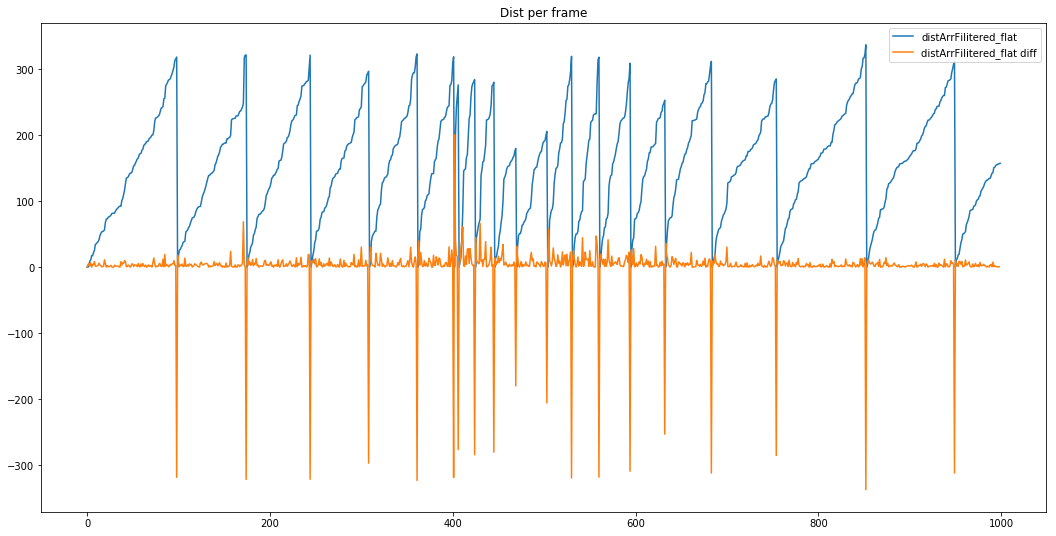

In [5]:
# 모든 유효한 dist 확인
print("distArrFilitered_flat_median:", statistics.median(distArrFilitered_flat))

distArrFilitered_flat = np.array(distArrFilitered_flat[:1000])
plt.figure(figsize=(18,9))
plt.plot(distArrFilitered_flat[:], label="distArrFilitered_flat")
plt.plot(distArrFilitered_flat[1:]-distArrFilitered_flat[:-1], label="distArrFilitered_flat diff")
plt.legend(loc='upper right')
plt.title("Dist per frame")
plt.show()

diff_median: 13579.5 , diff_mean: 24747.739852398525


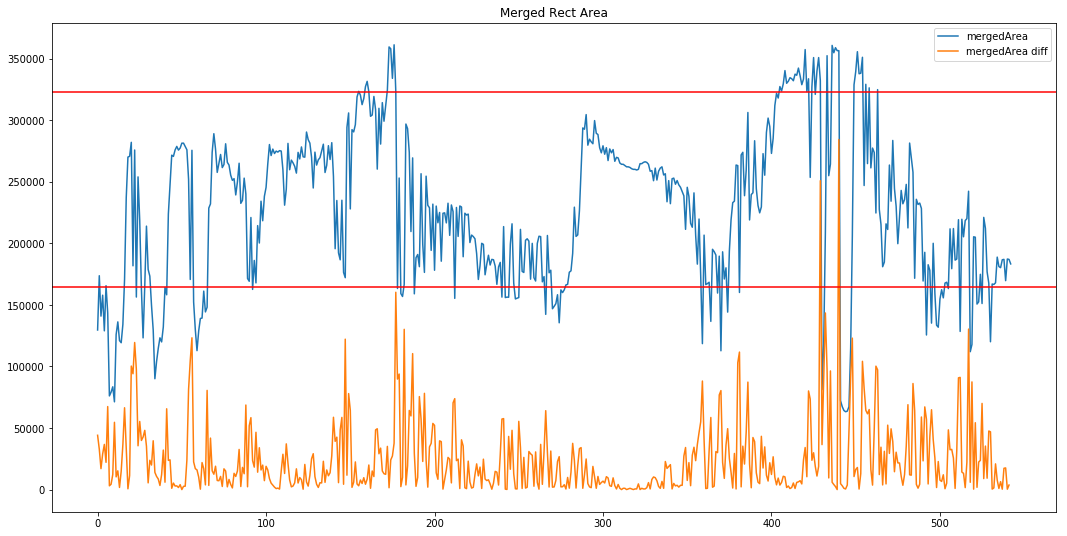

In [6]:
mergedAreas = np.array(mergedAreas)
diff = abs(mergedAreas[1:] - mergedAreas[:-1])
diff_median = statistics.median(diff)
diff_mean = np.sum(diff)/len(diff)

# 통계량 계산
var= sum([math.pow(i, 2) for i in mergedAreas]) / len(mergedAreas) - math.pow(mergedAreas.mean(), 2)
std = math.sqrt(var)
upperBound = mergedAreas.mean()+ std*1.5
lowerBound = mergedAreas.mean()- std

print("diff_median:", diff_median, ", diff_mean:", diff_mean)

mergedAreas = np.array(mergedAreas)
plt.figure(figsize=(18,9))
plt.plot(mergedAreas, label="mergedArea")
plt.plot(abs(mergedAreas[1:] - mergedAreas[:-1]), label="mergedArea diff")
plt.axhline(upperBound, color='r')
plt.axhline(lowerBound, color='r')
plt.legend(loc='upper right')
plt.title("Merged Rect Area")
plt.show()



diff_median: 0.0588231102640781 , diff_mean: 0.13029096976704277


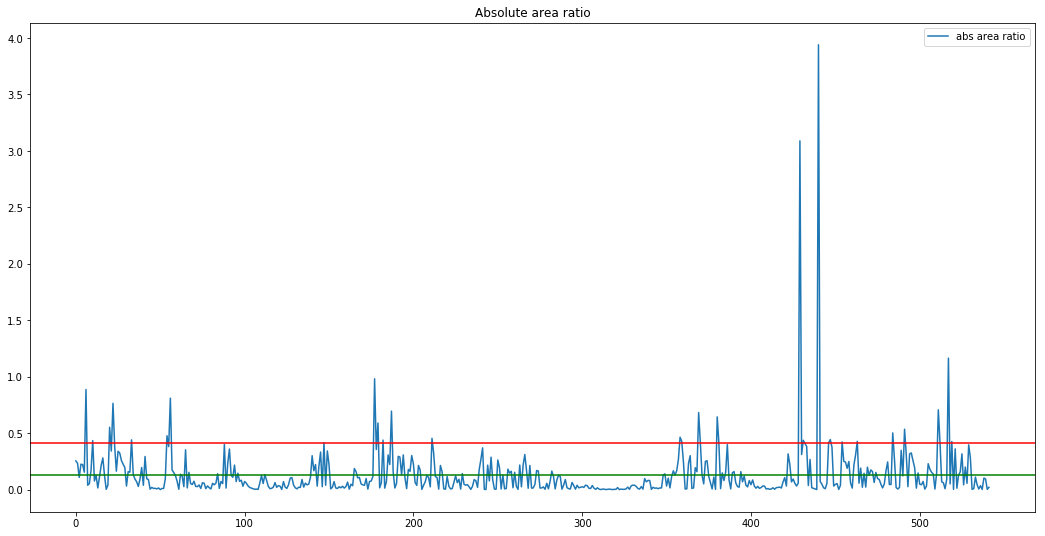

In [7]:
'''
개선방향
 - 차분값을 절대 면적 차이가 아니라 이전 면적에 대한 비로 해야함 [v]
 - 특이점에서 shrink_ratio 만큼 줄어들때 방향 고려하기 [v]
 - 맨처음, 맨 마지막 몇 프레임 제거하기 [v]
 - 디텍팅 영역 마진 조금 주기 [v]
 - 손, 팔 관련 처리가 사후로 한번 필요하긴 할듯...
'''
# 면적비 차분 통계량
mergedAreas = np.array(mergedAreas)
diff = abs(mergedAreas[1:] - mergedAreas[:-1])/mergedAreas[1:]
diff_median = statistics.median(diff)
diff_mean = np.sum(diff)/len(diff)

print('diff_median:', diff_median, ', diff_mean:', diff_mean)
plt.figure(figsize=(18,9))
plt.plot(diff, label="abs area ratio")
plt.axhline(diff_median*7, color='r')
plt.axhline(diff_mean, color='g')
plt.legend(loc='upper right')
plt.title("Absolute area ratio")
plt.show()

In [8]:
meanArea24Frame=[]
referenceAllData=[(0, i) for i in allData]

#0-23 frame mean
sum_ = 0
for i in range(0, 24):
    sum_ += mergedAreas[i]
    meanArea24Frame.append(sum_/(i+1))

#24-end 24 frame mean
for i in range(24,len(mergedAreas)):
    sum_ = 0
    for j in range(24):
        sum_ += mergedAreas[i-j]
    meanArea24Frame.append(sum_/24)

#check Area is much more bigger than mean (in this case twice)
for i in range(len(mergedAreas)):
#     print(i, meanArea24Frame[i], mergedAreas[i])
    if(mergedAreas[i]/meanArea24Frame[i] > 2):
        print(i, 'data :',mergedAreas[i], 'mean :',meanArea24Frame[i])
        j = 0
        while(1):
            j += 1
            if(mergedAreas[i-j]/meanArea24Frame[i-j] < 2):
                referenceAllData[i] = (1,allData[i-j])
                print(i, i-j, allData[i], allData[i-j],referenceAllData[i])
                break
        

In [11]:
%%time
cap = cv2.VideoCapture(videoPath)
videoname = videoPath.split('/')[-1].split('.')
videoname = videoname[0]
print(videoname)
idx = 0
shrink_ratio = 0.5 #  abnormal 관측시 5%씩 증감
shrink_ratio_s = 0.5
margin = 0.10 # 검출영역 마진
cnt = 0 # 저장용 프레임 체크용
save_cnt = 0 # 저장용 파일명 인덱스용
preRect = []
while(1):
    ret, frame = cap.read()
    if(ret):
        mergedRect = allData[idx]
#         cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
        if bool(preRect):
#             diff_area = calcArea(mergedRect)-calcArea(preRect)
#             if diff_median*7 < abs(diff_area):
            # 갑작스럽게 영역의 수축/팽창이 일어나는 경우
            diff_area = calcArea(mergedRect)-calcArea(preRect)
            if diff_median*7 < abs(diff_area)/calcArea(preRect) or referenceAllData[idx][0]: # 비율로 계산
                if(referenceAllData[idx][0]):
                    preRect = referenceAllData[idx][1]
                width = preRect[2]-preRect[0]
                height = preRect[3]-preRect[1]
                if diff_area>0: # 커지는 경우
                    cv2.putText(frame, str(idx)+' abnormal dilation', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)
                    # 이전 프레임보다 줄어들면 안됨... 어차피 팽창하는 경우라
                    x = max(preRect[0]*(1-shrink_ratio)+mergedRect[0]*shrink_ratio, 0)
                    y = max(preRect[1]*(1-shrink_ratio)+mergedRect[1]*shrink_ratio, 0)
                    x2 = min(preRect[2]*(1-shrink_ratio)+mergedRect[2]*shrink_ratio, videoWidth)
                    y2 = min(preRect[3]*(1-shrink_ratio)+mergedRect[3]*shrink_ratio, videoHeight) 
                    if (x2-x)>(mergedRect[2]-mergedRect[0]):
                        x = mergedRect[0]
                        x2 = mergedRect[2]
                    if (y2-y)>(mergedRect[3]-mergedRect[1]):
                        y = mergedRect[1]
                        y2 = mergedRect[3]
                        
                else: # 작아지는 경우
                    cv2.putText(frame, str(idx)+' abnormal shrinkage', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                    x = preRect[0]*(1-shrink_ratio_s)+mergedRect[0]*shrink_ratio_s
                    y = preRect[1]*(1-shrink_ratio_s)+mergedRect[1]*shrink_ratio_s
                    x2 = preRect[2]*(1-shrink_ratio_s)+mergedRect[2]*shrink_ratio_s
                    y2 = preRect[3]*(1-shrink_ratio_s)+mergedRect[3]*shrink_ratio_s
              
                mergedRect = (int(x), int(y), int(x2), int(y2))
        
        if idx>0: # 첫 프레임 무시
            preRect = mergedRect
            print(idx, 'll')
            # 마진 넣기
            detectedRect = (int(max(mergedRect[0]-width*margin/2, 0)),
                            int(max(mergedRect[1]-height*margin/2, 0)),
                            int(min(mergedRect[2]+width*margin/2, videoWidth)),
                            int(min(mergedRect[3]+height*margin/2, videoHeight)) )
            if(calcArea(detectedRect) > upperBound): cv2.putText(frame, 'UPPER BOUND', (detectedRect[0], detectedRect[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
            elif(calcArea(detectedRect) < lowerBound): cv2.putText(frame, 'LOWER BOUND', (detectedRect[0], detectedRect[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
            else: 
                cnt+=1
                # n번째마다 저장
                if(cnt% 10 ==0): 
                    save_cnt += 1
                    savedRect = saveImage(frame, detectedRect, videoname, save_cnt)
                    cv2.rectangle(frame, (savedRect[0], savedRect[1]), (savedRect[2], savedRect[3]), (255, 0, 0), 2)        
#                     cv2.imshow('frame',frame)
#                     sleep(0.5)
        cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
        cv2.rectangle(frame, (detectedRect[0], detectedRect[1]), (detectedRect[2], detectedRect[3]), (0, 255, 255), 2)
        cv2.imshow('frame',frame)
#         sleep(0.5)
#         cv2.imwrite('./img/'+str(videoname)+'_'+str(idx)+'.jpg', frame[detectedRect[1]:detectedRect[3], detectedRect[0]:detectedRect[2]]) # 이미지 저장

        k = cv2.waitKey(30) & 0xff 
        if k == 27: # esc
            break
            
    else: break
    idx += 1    
        
cap.release()
cv2.destroyAllWindows()        

BEYOND-ECO_DAILY_DEFENSE_SKIN_TONE


NameError: name 'detectedRect' is not defined

In [104]:
cap.release()
cv2.destroyAllWindows()      

# 수정한것

- if dist-predist>threshold: break # 센터 거리값으로 제한 - 우하단에 멀리있는거 머지하는것 방지. 너무 초기에는 작동안해야 함.
- 이전 프레임보다 줄어들면 안됨... 어차피 팽창하는 경우라
                    if (x2-x)>(mergedRect[2]-mergedRect[0]):
                        x = mergedRect[0]
                        x2 = mergedRect[2]
                         print('xxxxxxx')
                    if (y2-y)>(mergedRect[3]-mergedRect[1]):
                        y = mergedRect[1]
                        y2 = mergedRect[3]   
                        print('yyyyyyyy')